In [1]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sys, os
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from sklearn.metrics import f1_score, recall_score, precision_score

2022-09-09 02:14:40.399371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-09 02:14:40.401976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 02:14:40.401984: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

In [2]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(18,6))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()
    # return ax

## Load & Preprocess Data

In [3]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

In [4]:
df['lag_1'] = df['value'].shift(1)
df['lag_2'] = df['value'].shift(2)
df['lag_3'] = df['value'].shift(3)
df['lag_4'] = df['value'].shift(4)
df.fillna(0, inplace=True)

In [5]:
# df_hourly = df.resample('H').mean()

In [6]:
# Create a TimeSeries, specifying the time and value columns
# Set aside the last 20 percent of ts as a validation series
# series = TimeSeries.from_dataframe(df_hourly, value_cols='value')
# train, val = series[:-round(len(df_hourly) / 5)], series[-round(len(df_hourly) / 5):]

In [7]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
df['scaled'] = np_scaled
data = df[['value', 'lag_1', 'lag_2', 'lag_3', 'lag_4']]

## PCA

In [8]:
# pca = PCA(n_components=1)
# df['prediction'] = pca.fit_transform(df.drop('label', axis=1))

In [9]:
# plt.rcParams["figure.figsize"] = (18,6)
# df.prediction.plot()

## AutoEncoder

In [30]:
ae_clf = AutoEncoder(hidden_neurons =[5, 64, 64, 5], epochs=15)
ae_clf.fit(data)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 5)                 30        
                                                                 
 dropout_12 (Dropout)        (None, 5)                 0         
                                                                 
 dense_19 (Dense)            (None, 5)                 30        
                                                                 
 dropout_13 (Dropout)        (None, 5)                 0         
                                                                 
 dense_20 (Dense)            (None, 5)                 30        
                                                                 
 dropout_14 (Dropout)        (None, 5)                 0         
                                                                 
 dense_21 (Dense)            (None, 64)               

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=15,
      hidden_activation='relu', hidden_neurons=[5, 64, 64, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ff2fbec4280>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

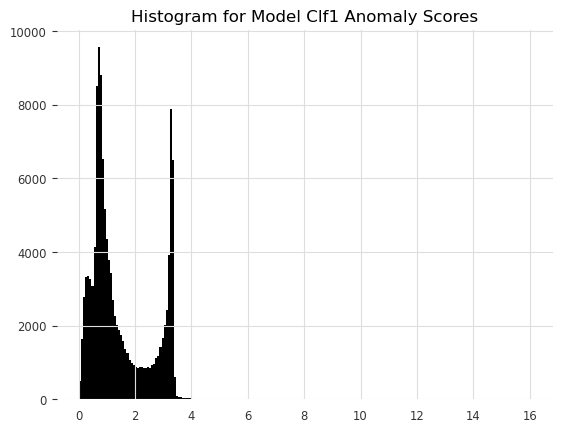

In [31]:
plt.hist(ae_clf.decision_scores_, bins='auto')
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [32]:
# Best fit score number is 1.54
ae_prediction_df = data.copy()
ae_prediction_df['score'] = ae_clf.decision_scores_ # outlier score
ae_prediction_df['prediction'] = np.where(ae_prediction_df['score'] < 3.4, 0, 1)
ae_prediction_df['prediction'].value_counts()
# df['label'].value_counts()
# ae_prediction_df.groupby('prediction').mean()

0    127127
1      1435
Name: prediction, dtype: int64

#### Visualization

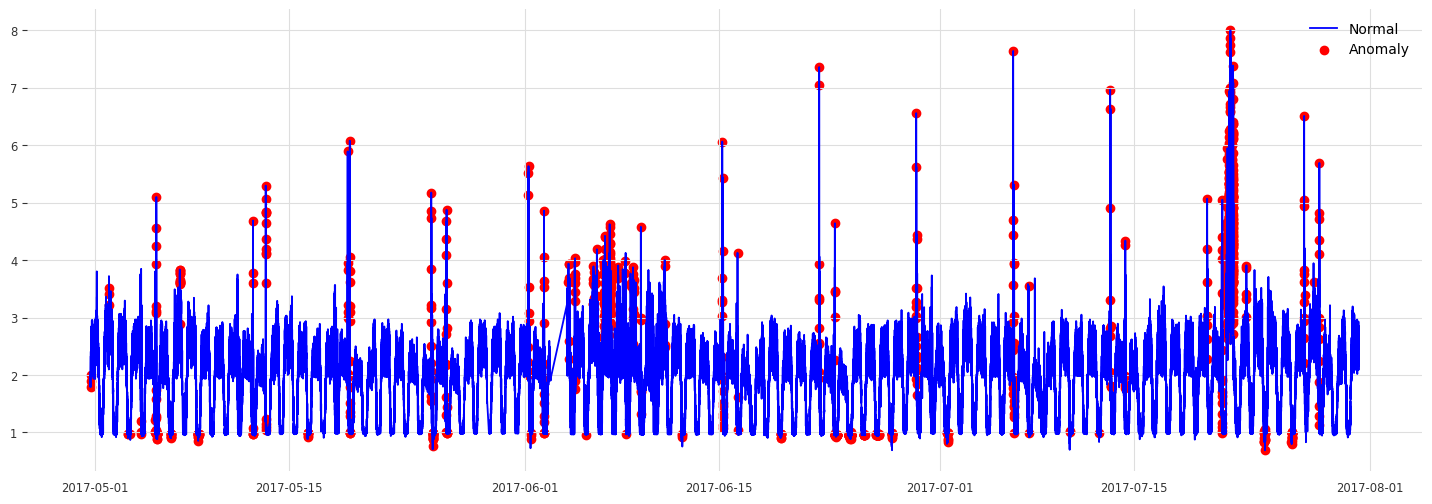

In [33]:
plot_outlier(ae_prediction_df)

#### Metrics

In [34]:
f1_score(df['label'], ae_prediction_df['prediction'])
# recall_score(df['label'], ae_prediction_df['prediction'])
# precision_score(df['label'], ae_prediction_df['prediction'])

0.17588652482269504

## VAE

In [15]:
vae_clf = VAE(encoder_neurons=[5, 32, 64], decoder_neurons=[64, 32, 5], epochs=15)
vae_clf.fit(data)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 5)            30          ['input_1[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 5)            30          ['dense_7[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 5)            0           ['dense_8[0][0]']                
                                                                                              

VAE(batch_size=32, capacity=0.0, contamination=0.1,
  decoder_neurons=[64, 32, 5], dropout_rate=0.2,
  encoder_neurons=[5, 32, 64], epochs=15, gamma=1.0,
  hidden_activation='relu', l2_regularizer=0.1, latent_dim=2,
  loss=<function mean_squared_error at 0x7ff2fbec4280>, optimizer='adam',
  output_activation='sigmoid', preprocessing=True, random_state=None,
  validation_size=0.1, verbose=1)

In [16]:
outlier_predict = vae_clf.predict(data)

4018/4018 [==============================] - 2s 543us/step


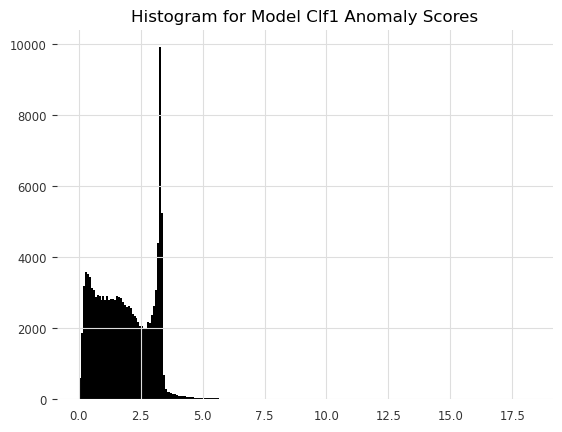

In [17]:
plt.hist(vae_clf.decision_scores_, bins='auto')
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [29]:
# Best fit score number is 1.54
vae_prediction_df = df.copy()
vae_prediction_df['score'] = vae_clf.decision_scores_
vae_prediction_df['prediction'] = np.where(vae_prediction_df['score'] < 3.4, 0, 1)
vae_prediction_df['prediction'].value_counts()
# df['label'].value_counts()
# ae_prediction_df.groupby('prediction').mean()

0    125009
1      3553
Name: prediction, dtype: int64

#### Visualization

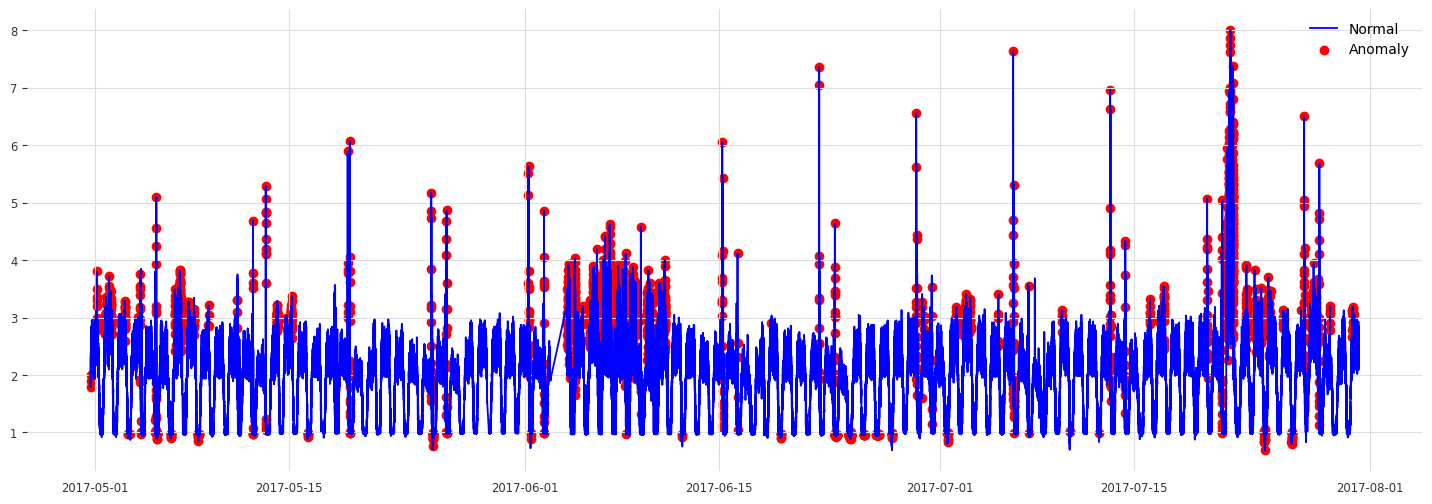

In [26]:
plot_outlier(vae_prediction_df)

#### Metrics

In [27]:
f1_score(df['label'], vae_prediction_df['prediction'])
# recall_score(df['label'], ae_prediction_df['prediction'])
# precision_score(df['label'], ae_prediction_df['prediction'])

0.31043040487839463